# Entity Linking Baseline on AIDA-YAGO Dataset

# 1. Load Libs & Data

## Install Needed Libs

In [0]:
! pip install gensim

## Mount Drive

In [0]:
from google.colab import drive

drive.mount('/content/drive')
drive_path = 'drive/My Drive/e2e_el/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Load Pretrained Word2vec

In [0]:
! cp drive/My\ Drive/e2e_el/GoogleNews-vectors-negative300.bin.gz word2vec300.bin.gz
! gunzip word2vec300.bin.gz

In [0]:
import pandas as pd
import numpy as np
import gensim

from gensim.models import KeyedVectors

vocab_size = 3 * 10**5
w2v = KeyedVectors.load_word2vec_format('word2vec300.bin', limit=vocab_size, binary=True)

vocab = ['UNK'] + list(w2v.vocab.keys())
word2id, id2word = {}, {}

for wid, w in enumerate(vocab):
  word2id[w] = wid
  id2word[wid] = w

In [0]:
from keras.layers import Embedding

word_vectors = np.zeros((vocab_size + 1, w2v.vector_size))
word_vectors[0] = np.zeros((w2v.vector_size,)) # change this to better vec

for i in range(1, vocab_size + 1):
  word_vectors[i] = w2v[id2word[i]]

Using TensorFlow backend.


In [0]:
w2v.similar_by_word('Jobs')

## Preprocess Wikipedia Dump

In [0]:
! wget https://dumps.wikimedia.org/archive/enwiki/20100312/enwiki-20100312-pages-articles.xml.bz2
! cp enwiki-20100312-pages-articles.xml.bz2 drive/My\ Drive/e2e_el/enwiki.xml.bz2

--2019-07-15 16:13:12--  https://dumps.wikimedia.org/archive/enwiki/20100312/enwiki-20100312-pages-articles.xml.bz2
Resolving dumps.wikimedia.org (dumps.wikimedia.org)... 208.80.155.106, 2620:0:861:4:208:80:155:106
Connecting to dumps.wikimedia.org (dumps.wikimedia.org)|208.80.155.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6117881141 (5.7G) [application/octet-stream]
Saving to: ‘enwiki-20100312-pages-articles.xml.bz2’

enwiki-20100312-pag 100%[===================>]   5.70G  1.97MB/s    in 49m 29s 

2019-07-15 17:02:42 (1.97 MB/s) - ‘enwiki-20100312-pages-articles.xml.bz2’ saved [6117881141/6117881141]



In [0]:
! cp drive/My\ Drive/e2e_el/enwiki.xml.bz2 enwiki.xml.bz2
! bzip2 -dk -v enwiki.xml.bz2

  enwiki.xml.bz2: done


In [0]:
! python WikiExtractor.py enwiki.xml -o enwiki -l --no_templates --processes 4 -q

In [0]:
# python 2.7

import os

def merge(in_dir, out_path):
        
    with open(out_path, 'w') as out_file:
        
        for sub_dir in sorted(os.listdir(in_dir)):
            print sub_dir, 
            file_dir = in_dir + '/' + sub_dir
            
            for in_name in sorted(os.listdir(file_dir)):
                with open(file_dir + '/' + in_name, 'r') as in_file:
                    for line in in_file:
                        out_file.write(line)

In [0]:
merge(in_dir='enwiki', out_path='enwiki_full.txt')

AA AB AC AD AE AF AG AH AI AJ AK AL AM AN AO AP AQ AR AS AT AU AV AW AX AY AZ BA BB BC BD BE BF BG BH BI BJ BK BL BM BN BO BP BQ BR BS BT BU BV BW BX BY BZ CA CB CC CD CE CF CG CH CI CJ CK CL CM CN CO CP CQ CR CS CT CU CV CW CX CY CZ DA DB DC DD DE DF DG DH DI DJ


In [0]:
! cp enwiki_full.txt drive/My\ Drive/e2e_el/enwiki_links_full.txt

## Load Wiki Entities

In [0]:
f = open('enwiki_full.txt', 'r')

In [5]:
print(f.readline() + f.readline() + f.readline() + f.readline() + f.readline() + f.readline())


Anarchism is a <a href="political%20philosophy">political philosophy</a> which considers the <a href="Sovereign%20state">state</a> undesirable, unnecessary and harmful, and instead promotes a stateless society, or <a href="anarchy">anarchy</a>. It seeks to diminish or even abolish authority in the conduct of human relations. Anarchists may widely disagree on what additional criteria are required in anarchism. "<a href="The%20Oxford%20Companion%20to%20Philosophy">The Oxford Companion to Philosophy</a>" says, "there is no single defining position that all anarchists hold, and those considered anarchists at best share a certain family resemblance."

There are many types and traditions of anarchism, not all of which are mutually exclusive. Strains of anarchism have been divided into the categories of <a href="social%20anarchism">social</a> and <a href="individualist%20anarchism">individualist anarchism</a> or similar dual classifications. Anarchism is often considered to be a radical left

In [0]:
from gensim.corpora import wikicorpus
from urllib.parse import unquote

In [0]:
! cp drive/My\ Drive/e2e_el/enwiki_links_full.txt enwiki_full.txt
# ! cp drive/My\ Drive/e2e_el/entities.pickle entities.pickle

In [0]:
import sys
from importlib import reload

sys.path.insert(0, '/content/drive/My Drive/colab_utils/')

In [0]:
import process_wiki

process_wiki = reload(process_wiki)

ent_max = 5500000     # 10 ** 7

name2wikiid, wikiid2name, id2wikiid, wikiid2id = process_wiki.load_entity_id_maps(
    ent_pickle_path='entites.pickle',
    ent_path='enwiki_full.txt',
    ent_max=ent_max)

ent_size = len(wikiid2id)

loaded entities from entites.pickle


In [0]:
list(name2wikiid.keys())[74524:74530]

['Locust Grove, Oklahoma',
 'Mazie, Oklahoma',
 'Murphy, Oklahoma',
 'Pensacola, Oklahoma',
 'Pin Oak Acres, Oklahoma',
 'Pryor Creek, Oklahoma']

In [0]:
# saving maps of entitiy to title words and vice versa

wikiid2wordids = {}
wid2freq = {}

def split_name(name):
  name = name.replace(',', '')
  name = name.replace('(', '').replace(')', '')
  return name.split(' ')

for eid, name in wikiid2name.items():
  
  words = {}
  
  for word in split_name(name):
    
    if word not in word2id:
      wid = len(word2id)
      word2id[word] = wid
      id2word[wid] = word
    else:
      wid = word2id[word]
    
    if wid in wid2freq:
      wid2freq[wid] += 1
    else:
      wid2freq[wid] = 1
    
    if word in words:
      words[wid] += 1
    else:
      words[wid] = 1
    
    wikiid2wordids[eid] = words

In [0]:
def gen_entity_mentions_map(wiki_path, name2wikiid, wikiid2id):

	hyp_pattern = re.compile(r'<a[^>]*href=\"([^\">]+)\"[^>]*>([^>]+)</a>', re.DOTALL | re.UNICODE)
	
	ignored_names = set()
	wikiid2mentions = {}
	
	with open(wiki_path, 'r', encoding='utf8') as inf:
	
		for line in inf:
      
      if len(wikiid2mentions) > 100:
        return wikiid2mentions
		
			clean_text = wikicorpus.filter_wiki(line)
			hyp_matches = re.finditer(hyp_pattern, line)


			for link in hyp_matches:

				name = unquote(link.groups()[0])   # wikipedia url id
				mention = link.groups()[1]
				
				if name in name2wikiid:
					wikiid = name2wikiid[name]
					if wikiid not in wikiid2mentions:
						wikiid2mentions[wikiid] = []
					wikiid2mentions[wikiid].append(mention)
				else:
					ignored_names.add(name)
	
	return wikiid2mentions


In [0]:
import numpy as np
from keras.layers import Embedding

# vector_size = 300
# entity_vectors = np.random.uniform(low=-1, high=1.0,
#                                    size=(ent_size+1, vector_size))
# entity_vectors = np.memmap('ent2rand300.bin', 
#                            dtype='float32', mode='w+',
#                            shape=(ent_size+1, vector_size))

# entity_vectors[0] = np.zeros((vector_size,))   # unk entity

# normalize ent vec

## Prepare AIDA-YAGO Dataset

In [0]:
! cp drive/My\ Drive/e2e_el/aida-yago2-dataset.tsv aida-yago2-dataset.tsv
# ! wget http://resources.mpi-inf.mpg.de/yago-naga/aida/download/aida_means.tsv.bz2
# ! bzip2 -dk aida_means.tsv.bz2# 

In [0]:
import sys
import process_aida
from importlib import reload

sys.path.insert(0, '/content/drive/My Drive/colab_utils/')
process_aida = reload(process_aida)

process_aida.split_aida(aida_path='aida-yago2-dataset.tsv')

aida splitted to aida-train.tsv, aida-testa.tsv, aida-testb.tsv


In [0]:
for word, wikiid in process_aida.gen_mentions('aida-train.tsv'):
  
  if word not in word2id:
    wid = len(word2id)
    word2id[word] = wid
    id2word[wid] = word
  else:
    wid = word2id[word]
    
  if wid in wid2freq:
    wid2freq[wid] += 1
  else:
    wid2freq[wid] = 1
      
  if wikiid not in wikiid2wordids:
    wikiid2wordids[wikiid] = {}
      
  if wid in wikiid2wordids[wikiid]:
    wikiid2wordids[wikiid][wid] += 1
  else:
    wikiid2wordids[wikiid][wid] = 1
    
for _, wordfreqs in wikiid2wordids.items():
  for wid in wordfreqs.keys():
    wordfreqs[wid] /= wid2freq[wid]
    
wid2wikiids = {}

for wikiid, wordids in wikiid2wordids.items():
  for wid in wordids:
    if wid not in wid2wikiids:
      wid2wikiids[wid] = {}
    wid2wikiids[wid][wikiid] = wikiid2wordids[wikiid][wid]

In [0]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def data_from_generator(gen, begin_inside_weight=4):
  
  data_x, data_y = [], []
  data_w = []
  lengths = []
  
  for (x, y) in gen:
    lengths.append(len(x))
    data_x.append(x)
    data_y.append(y)

  data_x = pad_sequences(data_x, maxlen=max(lengths), value=0, dtype=np.int32,
                         padding='post', truncating='post')
  data_y = pad_sequences(data_y, maxlen=max(lengths), value=0, dtype=np.int32,
                         padding='post', truncating='post')
  
  data_w = np.ones(data_y.shape)
  data_w[data_y > 0] = begin_inside_weight

  data_y = to_categorical(data_y, num_classes=3, dtype=np.int32)
  
  return data_x, data_y, data_w, max(lengths)

In [0]:
train_gen = process_aida.gen_md_data(aida_path='aida-train.tsv',
                                     word2id=word2id)
valid_gen = process_aida.gen_md_data(aida_path='aida-testa.tsv',
                                     word2id=word2id)

train_x, train_y, train_w, max_len_train = data_from_generator(train_gen)
valid_x, valid_y, valid_w, max_len_valid = data_from_generator(valid_gen)

ys = {0: 158121, 1: 22866, 2: 10484}

max_len = max(max_len_train, max_len_valid)
print(len(train_x), len(valid_x), max_len)

946 216 1018


# 2. Define Baseline Model

In [0]:
from keras import backend as K

def f1(y_true, y_pred):
  
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
      
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Design & Train Mention Detector

In [0]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

word_ids = Input(shape=(None,), name='input')
x = Embedding(len(word_vectors), output_dim=300, weights=[word_vectors], trainable=False, name='w2v')(word_ids)
x = Bidirectional(LSTM(units=300, return_sequences=True, recurrent_dropout=0.1, name='lstm1'))(x)
x = Bidirectional(LSTM(units=30, return_sequences=True, recurrent_dropout=0.1, name='lstm2'))(x)
output = TimeDistributed(Dense(3, activation='softmax'))(x)

model = Model(word_ids, output)

model.compile(optimizer='adam', loss='categorical_crossentropy',
              sample_weight_mode='temporal',
              metrics=['accuracy', f1])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, None)              0         
_________________________________________________________________
w2v (Embedding)              (None, None, 300)         90000300  
_________________________________________________________________
bidirectional_4 (Bidirection (None, None, 600)         1442400   
_________________________________________________________________
bidirectional_5 (Bidirection (None, None, 60)          151440    
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 3)           183       
Total params: 91,594,323
Trainable params: 1,594,023
Non-trainable params: 90,000,300
_________________________________________________________________


In [0]:
history = model.fit(x=train_x, y=train_y, sample_weight=train_w,
                    validation_data=(valid_x, valid_y, valid_w),
                    batch_size=64, epochs=20, verbose=1)

model.save('md_model.h5')
! cp md_model.h5 drive/My\ Drive/e2e_el/md_model.h5

Train on 946 samples, validate on 216 samples
Epoch 1/20
946/946 [==============================] - 108s 115ms/step - loss: 0.6963 - acc: 0.9404 - f1: 0.6861 - val_loss: 0.3944 - val_acc: 0.9443 - val_f1: 0.9442
Epoch 2/20
946/946 [==============================] - 103s 109ms/step - loss: 0.2825 - acc: 0.9589 - f1: 0.9551 - val_loss: 0.3168 - val_acc: 0.9528 - val_f1: 0.9527
Epoch 3/20
946/946 [==============================] - 105s 111ms/step - loss: 0.2397 - acc: 0.9599 - f1: 0.9601 - val_loss: 0.2689 - val_acc: 0.9507 - val_f1: 0.9518
Epoch 4/20
946/946 [==============================] - 104s 110ms/step - loss: 0.1954 - acc: 0.9689 - f1: 0.9698 - val_loss: 0.2064 - val_acc: 0.9710 - val_f1: 0.9722
Epoch 5/20
946/946 [==============================] - 104s 110ms/step - loss: 0.1515 - acc: 0.9800 - f1: 0.9803 - val_loss: 0.1588 - val_acc: 0.9808 - val_f1: 0.9808
Epoch 6/20
946/946 [==============================] - 105s 110ms/step - loss: 0.1221 - acc: 0.9847 - f1: 0.9847 - val_loss: 

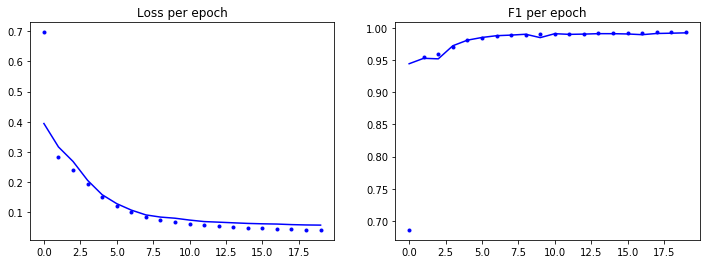

In [0]:
from matplotlib import pyplot as plt
from pylab import rcParams

rcParams['figure.figsize'] = 12, 4

plt.subplot(1, 2, 1)
plt.title('Loss per epoch')
plt.plot(history.history['loss'], 'b.')
plt.plot(history.history['val_loss'], 'b-')

plt.subplot(1, 2, 2)
plt.title('F1 per epoch')
plt.plot(history.history['f1'], 'b.')
plt.plot(history.history['val_f1'], 'b-')
plt.show()

In [0]:
def predict_iob(wids):
  
  global model
  
  if type(wids) is list:
    word_ids = np.array(wids)
  else:
    word_ids = wids

  iobs = model.predict(word_ids.reshape(1, -1), batch_size=1).reshape(-1, 3)
  iobs = np.argmax(iobs[:len(wids)], axis=-1)

  return iobs

## Simple Entity Disambiguator

In [0]:
def baseline_disamb(mention, word2id, wid2wikiids, epsilon=0.001):
    
  candidates = {}
  
  if type(mention) is str:
    mention_words = list(filter(lambda w: w in word2id, split_name(mention)))
    mention_ids = list(map(lambda w: word2id[w], mention_words))

  elif type(mention) is list and type(mention[0]) is str:
    mention_ids = list(map(lambda w: word2id[w], mention))
    
  else:
    mention_ids = mention
  
  for wid in mention_ids:
    if wid not in wid2wikiids:
      continue
    for wikiid, score in wid2wikiids[wid].items():
      if wikiid in candidates:
        candidates[wikiid][wid] = score
      else:
        candidates[wikiid] = {wid: score}
  
  scores = {}
  
  for wikiid, word_scores in candidates.items():
    score = 0
    for wid, sc in word_scores.items():
      score += sc
    scores[wikiid] = score
    
  
  max_score, best_candidate = 0, -1   # unk entity id
  for cand, score in scores.items():
    if score > max_score:
      max_score = score
      best_candidate = cand
      
  return best_candidate

In [0]:
wikiid2name[baseline_disamb('Barcelona', word2id, wid2wikiids)]

'FC Barcelona'

In [0]:
def disamb_tagged_doc(wids, iobs):
  
  best = {}
  
  start, end = -1, -1
  
  for idx, tag in enumerate(iobs):
    if tag in [0, 1] and start >= 0:
      best[f'{start}:{end}'] = baseline_disamb(wids[start:end+1], word2id, wid2wikiids)
      start, end = -1, -1
      
    if tag == 1:    # iob_b
      start, end = idx, idx
      
    if tag == 2:
      end = idx
      
  if start >= 0:
    best[f'{start}:{end}'] = baseline_disamb(wids[start:end+1], word2id, wid2wikiids)
      
  return best

# 3. Evaluate Model

## Load Saved Mention Detector

In [0]:
import os
from keras.models import load_model

if not os.path.exists('md_model.h5'):
  ! cp drive/My\ Drive/e2e_el/md_model.h5 md_model.h5

model = load_model('md_model.h5', custom_objects={'f1': f1})

## Test Model With Arbitary Input Text

In [0]:
def text_to_entity_names(text, human_readable=True):
  
  clean = [w for w in text.split(' ') if w in word2id]
  word_ids = np.array([word2id[w] for w in clean])
  
  iobs = predict_iob(word_ids)
  disambiguated = disamb_tagged_doc(word_ids, iobs)

  if not human_readable:
    return disambiguated
  
  human_readable = {}
  
  for boundary, wikiid in disambiguated.items():
    start, end = tuple(map(int, boundary.split(':')))
    mention = ' '.join([f'[{boundary:5s}]'] + clean[start:end+1])
    human_readable[mention] = wikiid2name[wikiid]
  
  return human_readable

In [0]:
from_testa = 'They were held up by a gritty 84 from Paul Johnson but ex-England fast bowler Martin McCague took four for 55 .'
politics = sentence = 'President Barack Obama last week said he will impose a blanket tariff on Mexican imports from June 10 to try to pressure Mexico to tackle large flows of mostly Central American migrants passing through en route to the United States'
sports = 'Barcelona plays with Sevilla'

text_to_entity_names(politics)

{'[13:13] Mexican': 'Mexico',
 '[1:2  ] Barack Obama': 'Barack Obama',
 '[22:22] Mexico': 'Mexico',
 '[29:30] Central American': 'United States',
 '[38:39] United States': 'United States'}

## Functions to evaluate Model

In [0]:
def count_correct(predicted, gold, strong_match=True, return_totals=True):
  
  total_pred, total_gold = len(predicted), len(gold)
  correct = 0
  
  if strong_match:
    for b in predicted.keys():
      if b in gold and predicted[b] == gold[b]:
        correct += 1
  else:
    for b, e in gold.items():
      for pb, pe in predicted.items():
        if pe == e:
          g_start, g_end = int(b.split(':')[0]), int(b.split(':')[1])
          p_start, p_end = int(pb.split(':')[0]), int(pb.split(':')[1])
          if p_start in range(g_start, g_end+1) or p_end in range(g_start, g_end+1):
            correct += 1

  if return_totals:
    return correct, total_pred, total_gold
  else:
    return correct

In [0]:
from commons import show_progress

def calculate_micro_f1(aida_path='aida-testa.tsv', total_docs=216, strong_match=True):
  
  total_pred = 0       # number of entities in predictions
  total_gold = 0       # number of gold entities in test set
  correct = 0          # number of predicted entities that match entity
                       # and boundary (in strong match)
  doc_idx = 0

  for wids, golds in process_aida.gen_doc_with_golds(aida_path, word2id):

    show_progress(percent=doc_idx/total_docs)
    
    iobs = predict_iob(wids)
    predicted = disamb_tagged_doc(wids, iobs)
    corr, tot_pred, tot_gold = count_correct(predicted, golds,
                                            strong_match=strong_match)
    total_pred += tot_pred
    correct += corr
    total_gold += tot_gold
    
    doc_idx += 1
  
  show_progress(percent=1.0, done=True)
  
  precision, recall = correct/total_pred, correct/total_gold
  f_score = (2 * precision * recall) / (precision + recall)
  
  return precision, recall, f_score

## Micro F1 Scores for Baseline

In [0]:
precision, recall, f_score = calculate_micro_f1(strong_match=False)
print(f'evaluation on aida validation set with weak matching:')
print(f'precision: {precision:.3f}\nrecall:    {recall:.3f}\nf1-score:  {f_score:.3f}')

[===================================================] 100% done!
evaluation on aida validation set with weak matching:
precision: 0.556
recall:    0.728
f1-score:  0.631


In [0]:
precision, recall, f_score = calculate_micro_f1(strong_match=True)
print(f'evaluation on aida validation set with strong matching:')
print(f'precision: {precision:.3f}\nrecall:    {recall:.3f}\nf1-score:  {f_score:.3f}')

[===================================================] 100% done!
evaluation on aida validation set with strong matching:
precision: 0.524
recall:    0.686
f1-score:  0.594


In [0]:
precision, recall, f_score = calculate_micro_f1(aida_path='aida-testb.tsv',
                                                strong_match=False)
print(f'evaluation on aida test set with weak matching:')
print(f'precision: {precision:.3f}\nrecall:    {recall:.3f}\nf1-score:  {f_score:.3f}')

[===================================================] 100% done!
evaluation on aida test set with weak matching:
precision: 0.448
recall:    0.619
f1-score:  0.520


In [0]:
precision, recall, f_score = calculate_micro_f1(aida_path='aida-testb.tsv',
                                                strong_match=True)
print(f'evaluation on aida test set with strong matching:')
print(f'precision: {precision:.3f}\nrecall:    {recall:.3f}\nf1-score:  {f_score:.3f}')

[===================================================] 100% done!
evaluation on aida test set with strong matching:
precision: 0.415
recall:    0.573
f1-score:  0.481


# 4. Extras

In [0]:
import sys

ram = 0

for var, obj in locals().items():
  if sys.getsizeof(obj) > 10**6:
    print(f'{var:16s}: {sys.getsizeof(obj) / 10**6}')
  ram += sys.getsizeof(obj)

print(f'used ram: {ram / 10**6}')